In [1]:
%matplotlib inline

from enum import Enum

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import tensorflow as tf
from ipywidgets import interact, IntSlider

from boundary import plot_decision_boundary

np.random.seed(0)

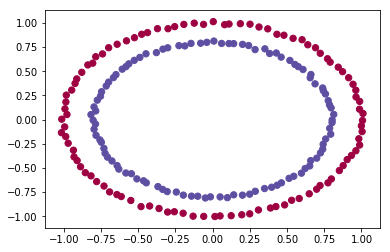

In [2]:
X_train, Y_train = sklearn.datasets.make_circles(1000, noise=1e-2)
X_validate, Y_validate = sklearn.datasets.make_circles(200, noise=1e-2)
#X_train, Y_train = sklearn.datasets.make_moons(200, noise=0.05)
#X_validate, Y_validate = sklearn.datasets.make_moons(200, noise=0.05)
plt.scatter(X_validate[:,0], X_validate[:,1], s=40, c=Y_validate, cmap=plt.cm.Spectral)

In [3]:
class Phase(Enum):
    Train = 0
    Validation = 1
    Predict = 2

In [4]:
class Model:
    def __init__(self, batch_size, input_dims, hidden_sizes = [], phase = Phase.Predict):
        self._x = tf.placeholder(tf.float32, shape=[batch_size, input_dims])
        
        if phase != Phase.Predict:
            self._y = tf.placeholder(tf.int64, shape=[batch_size])

        hidden = self.hidden_layers(self.x, hidden_sizes)

        #hidden_W = tf.get_variable("hidden_w", [self.x.shape[1], 20])
        #hidden_b = tf.get_variable("hidden_b", [20])
        #hidden = tf.matmul(self.x, hidden_W) + hidden_b
        #hidden = tf.nn.sigmoid(hidden)
        
        w = tf.get_variable("w", shape = [hidden.shape[1], 1])
        b = tf.get_variable("b", shape = [1])
        
        logits = tf.matmul(hidden, w) + b
        logits = tf.reshape(logits, [-1])

        if phase == Phase.Train:
            losses = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.cast(self.y, tf.float32), logits = logits)
            self._loss = loss = tf.reduce_sum(losses)
            
            self._train_op = tf.train.GradientDescentOptimizer(0.003).minimize(loss)
        else:
            self._probs = probs = tf.sigmoid(logits)
            self._labels = tf.cast(tf.round(probs), tf.int64)
            
        if phase == Phase.Validation:
            correct = tf.equal(self.y, self._labels)
            self._accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    def hidden_layers(self, input_layer, hidden_sizes):    
        for (i, hidden_size) in enumerate(hidden_sizes):
            W = tf.get_variable("W_hidden_%d" % i, shape = [input_layer.shape[1], hidden_size])
            b = tf.get_variable("b_hidden_%d" % i, shape = [hidden_size])
            hidden_outputs = tf.sigmoid(tf.matmul(input_layer, W) + b)
            input_layer = hidden_outputs
        
        return input_layer
            
            
    @property
    def x(self):
        return self._x
        
    @property
    def y(self):
        return self._y
    
    @property
    def labels(self):
        return self._labels

    @property
    def loss(self):
        return self._loss

    @property
    def train_op(self):
        return self._train_op

    @property
    def probs(self):
        return self._probs
        
    @property
    def accuracy(self):
        return self._accuracy

In [5]:
tf.reset_default_graph()

sess = tf.Session()

hidden_sizes = [20]

with tf.variable_scope("model", reuse=False):
    train_model = Model(X_train.shape[0], X_train.shape[1], hidden_sizes = hidden_sizes, phase = Phase.Train)
        
with tf.variable_scope("model", reuse=True):
    validation_model = Model(X_validate.shape[0], X_validate.shape[1], hidden_sizes = hidden_sizes, phase = Phase.Validation)
    
with tf.variable_scope("model", reuse=True):
    predict_model = Model(1000, X_train.shape[1], hidden_sizes = hidden_sizes, phase = Phase.Predict)
    
sess.run(tf.global_variables_initializer())

for i in range(1000):
    epoch_loss, _ = sess.run([train_model.loss, train_model.train_op],
                            {train_model.x: X_train, train_model.y: Y_train})
    accuracy, = sess.run([validation_model.accuracy],
                            {validation_model.x: X_validate, validation_model.y: Y_validate})
    if i%100 == 0:
        print(epoch_loss, accuracy)

1195.98 0.5
692.635 0.52
690.313 0.54
677.413 0.58
627.353 0.665
518.584 0.61
312.216 0.995
180.697 1.0
123.485 1.0
90.0569 1.0


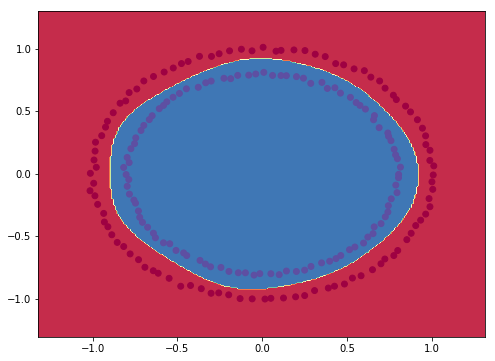

In [6]:
fig = plt.figure(figsize=(8, 6))
sub = fig.add_subplot(111)

def classify(x):
    return sess.run([predict_model.labels], {predict_model.x: x})[0]

plot_decision_boundary(sub, lambda x: classify(x), X_validate, Y_validate,
                           batch_size = 1000,
                           x_range = (X_validate[:,0].min(), X_validate[:,0].max()),
                           y_range = (X_validate[:,1].min(), X_validate[:,1].max()))

In [7]:
sess.close()